In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time

In [4]:
metro=pd.read_csv("metro.csv")
taxi=pd.read_csv("taxi.csv")
tw=pd.read_csv("tweets.csv")

In [ ]:
#plot distributions
hourly_tw = []
for i in range(24):
    hourly_tw.append(tw[tw['hour'] == i].shape[0])
hours = [i for i in range(24)]

mly_tw = []
for i in range(5,13):
    mly_tw.append(tw[tw['month'] == i].shape[0])
months = ['May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']

dw_tw = []
for i in range(7):
    dw_tw.append(tw[tw['dayw'] == i].shape[0])
ds = ['Mon','Tues','Wed','Thu','Fri','Sat','Sun']

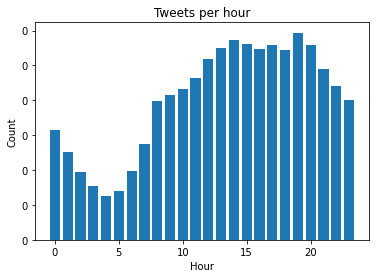

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
 
fig, ax = plt.subplots(1, 1)



plot = plt.bar(hours,[x / 100000000 for x in hourly_tw])


fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 


plt.title("Tweets per hour")
plt.xlabel("Hour")
plt.ylabel("Count")
 

plt.show()

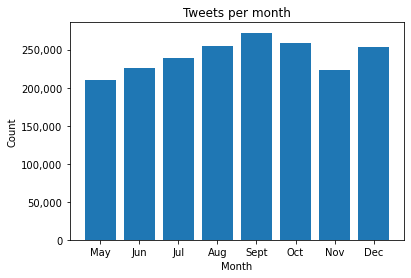

In [20]:
fig, ax = plt.subplots(1, 1)

plot = plt.bar(months,mly_tw)

plt.title("Tweets per month")
plt.xlabel("Month")
plt.ylabel("Count")
 
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.show()

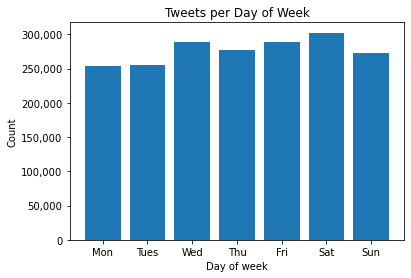

In [21]:
fig, ax = plt.subplots(1, 1)

plot = plt.bar(ds,dw_tw)

plt.title("Tweets per Day of Week")
plt.xlabel("Day of week")
plt.ylabel("Count")
 
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.show()

In [10]:
#get events and compare to traffic data
from collections import Counter

def get_Event_keys(df1,days,hours,tx,ty):
    
    temp = df1[(df1.x == tx) & (df1.y == ty)]
    #print(temp)
    tags = []
    for i in range(len(days)):
        td = days[i]
        th = hours[i]
        temp2 = temp[(temp.day == td) & (temp.hour == th)]
        s=" ".join(temp2['text']).split(" ")
        meaningless = ["#nyc","#newyork","#newyork,","#hiring","#job","#jobs"]
        s = [si for si in s if "#" in si and not any(ml == si.lower() for ml in meaningless)]
        s = [si.lower() for si in s]
        c=Counter(s).most_common(3)
        tags.append(c)
        
    return tags

def count_tw(df,tx,ty):
    result = dict()
    mdays = max(df['day'].unique())
    for h in range(24):
        result[h] = [0] * mdays
    
    temp = df[(df.x == tx) & (df.y == ty)]
    for di,dfi in temp.groupby(['day','hour']):
        day = di[0]
        hour = di[1]

        result[hour][day-1]+=dfi.shape[0]

    return result

#check for all events

def get_events(df,ty,tx):
    #df of target month
    #target y, target x, cell numbers
    
    CT=count_tw(df,tx,ty)

    
    mdays = df['day'].nunique()

    days = []
    hours = []
    counts1 = []
    
    

    for hour in range(24):
        counts = CT[hour]
        for day in range(mdays): #Noet: day starts at 0
            mycount = counts[day]
            temp = counts[:]
            del temp[day]
            avg = np.mean(temp)
            std = np.std(temp)
            if mycount > avg + std*2 and mycount > 10: #at least 10 to be an event           
                days.append(day+1)
                hours.append(hour)
                counts1.append(mycount)
              
                
    res = pd.DataFrame()
    res['month'] = [df['month'].iloc[1]] * len(days)
    res['day'] = days 
    res['hour'] = hours
    res['count'] = counts1        
    tags = get_Event_keys(df,days,hours,tx,ty)
    res['tags'] = tags
    
    return res.sort_values(by=['day', 'hour'])    

def get_allyear(df,ty,tx):
    first = 1
    for mon in range(5,13):
        dftemp = df.loc[df['month'] == mon]
        res = get_events(dftemp,ty, tx)
        if first == 1:
            df1 = res
            first = 0
        else:
            df1=pd.concat([df1, res])
    df1 = df1.astype({'month': 'int32','day': 'int32','hour': 'int32','count': 'int32'})
    
    return pick(df1)

def pick(df1):  #pick rows with at least 3 repated hashtags
    df1['clean'] = df1['tags'].map(clean)
    return df1[df1['clean'] == 1].drop(['clean'],axis=1)

def clean(tag):
    try:
        if tag[0][1] >= 3:
            return 1
        else:
            return 0
    except:
        return 0
    
def aggEvents(df):
    h = np.nan
    m= np.nan
    d = np.nan
    dur = 1
    durs = []
    mark = []
    for i,row in df.iterrows():
        if row.month == m and row.day == d and row.hour - h == 1:
            mark.append(1)
            dur += 1
        else:
            if dur > 1:
                durs[-1] = dur
                dur = 1
            mark.append(0)
            durs.append(dur)
        h = row.hour
        m = row.month
        d = row.day
        
    df['mark'] = mark
    df = df[df.mark != 1]
    df['duration'] = durs
    df=df.drop(columns=['mark'])
    new_order = [0,1,2,3,5,4]
    df = df[df.columns[new_order]]    
    return df



def findcs(lst,num):
    i = 0
    lst = sorted(lst)
    for x in lst:
        if x >= num and i > 0:
            return lst[i-1]
        elif x >= num and i == 0:
            return lst[-1]
        i += 1
    return lst[-1]

def get_metro(m,d,h, stations):

    """
    example:
    m = 8
    d = 31
    h = 17
    stations = ['34 ST-PENN STA','34 ST-HERALD SQ']
    """

    dw = datetime.datetime(2015, m, d).weekday() #day of week
    if dw >=5:
        temp = metro[(metro.MONTH == m) & (metro.DAYW >= 5)]
    else:
        temp = metro[(metro.MONTH == m)& (metro.DAYW < 5)]
        
    avgs = []
    flows = []

    for sta in stations:
        
        here = temp[(temp.DAY == d)  & (temp.STATION == sta)]  
        sta_hours = here.HOUR.unique()
        #pickhour = findcs(sta_hours,h)
        if len(sta_hours) > 0:
            pickhour = sorted(sta_hours, key=lambda x: abs(x - h))[0]
            here = here[(here.HOUR == pickhour)]
            flowhere =  int(here.HOURLY_EXITS2.sum()) 

            temp1 = temp[(temp.STATION == sta) & (temp.HOUR == pickhour)]
            avg = int(temp1.HOURLY_EXITS2.sum()/temp1.DATE.nunique()) 

            avgs.append(avg)
            flows.append(flowhere)
        else:#no service on that day
            avgs.append(1)
            flows.append(1)
    
    #total_avg = sum(avgs)
    #total_event = sum(flows)
    
    #return '{0:.2f}%'.format(100*(sum(flows)-sum(avgs))/sum(avgs))
    return (sum(flows)-sum(avgs))/sum(avgs)

def get_taxi(m,d,h,tx,ty):

    """
    #example:
    m = 8
    d = 31
    h = 17
    tx=117
    ty=102
    """


    temp= taxi1[(taxi1.month == m) & ((taxi1.hour == h) | (taxi1.hour == h - 1))]
    avg = temp.shape[0] / temp.day.nunique()

    here = temp[temp.day == d]
    flowhere = here.shape[0]

    return (flowhere - avg) / avg

from math import sin, cos, sqrt, atan2, radians

def getDist(x1,y1,x2,y2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(y1)
    lon1 = radians(x1)
    lat2 = radians(y2)
    lon2 = radians(x2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

metrogeo = pd.read_csv('metro_geocoded.csv')
metrogeo=metrogeo.drop_duplicates(subset=['STATION'])

def findStation(long1,lat1):
    lst = []
    lx = list(metrogeo.X)
    ly = list(metrogeo.Y)
    for i in range(metrogeo.shape[0]):
        dist = getDist(lx[i],ly[i],long1,lat1) * 1000
        lst.append(dist)
    metrogeo['DIST'] = lst
    temp=metrogeo[metrogeo.DIST < 1000]
    temp=temp.sort_values(by=['DIST'])  
    
    return list(temp.STATION[:3])

dlat,dlong = 0.0017966305682364236, 0.0023700606427610182
difflong,difflat=273,251

#tells you which cell the given coord is in
#x = long, y = lat
def inside(y,x):
    x = x - (-74.2721)
    y = y - (40.48296)
    x = int(x / dlong) 
    y = difflat - 1 - int(y / dlat)
    
    return y,x  

def getlonglat(y,x):
    x = x *dlong - 74.2721
    y = 40.48296 + (250- y) * dlat

    return x+dlong/2,y+dlat/2

In [ ]:
def Run_process(ty,tx):
    #ty,tx=inside(lat1,long1)
    res = get_allyear(tw,ty,tx)
    res = aggEvents(res)
    long1,lat1 = getlonglat(y,x)
    mystations = findStation(long1,lat1)
    try:
        res['metro'] = res.apply(lambda x: get_metro(x.month, x.day, x.hour, mystations), axis=1)
    except:
        res['metro'] = 0
    try:
        taxi1 = taxi[(abs(taxi.x - tx) <=2) & (abs(taxi.y - ty) <=2)]
        res['taxi'] = res.apply(lambda x: get_taxi(x.month, x.day, x.hour, tx,ty), axis=1)
    except:
        res['taxi'] = 0
    res['Label'] = ((res['metro'] >= 0) & (res['taxi'] >= 0))
    
    return res

In [ ]:
allres = pd.DataFrame()
errors=[]
for x1 in range(max(tw.x)):
    for y1 in range(200,max(tw.y)):
        temp1 = tw[(tw.x == x1) & (tw.y == y1)]
        if temp1.shape[0] > 0:
            try:
                res1 = Run_process(y1,x1)
                allres = pd.concat([allres,res1])
            except Exception as e:
                print(e)
                errors.append([x1,y1])

In [13]:
res.head()

,ID,month,day,hour,count,duration,tags,tx,ty,metro,taxi
0,108.0,9.0,11.0,19.0,22.0,3.0,"[('#givenchy', 10), ('#nyfw', 8), ('#grtnyc17'...",108.0,118.0,1.127370,1.443883
1,109.0,9.0,19.0,4.0,11.0,1.0,"[('#thefashionshow', 11), ('#celbrity', 11), (...",108.0,118.0,1.093254,1.545833
2,110.0,11.0,18.0,19.0,12.0,1.0,"[('#outintech', 6), ('#futureofmobilepayments'...",108.0,122.0,0.889825,1.013806
3,111.0,9.0,11.0,5.0,15.0,1.0,"[('#mayweneverforget', 3), ('#twintowers', 2),...",108.0,124.0,1.167808,1.041647
4,112.0,9.0,11.0,10.0,14.0,1.0,"[('#neverforget', 3), ('#worldtradecenter', 2)...",108.0,124.0,0.993048,0.809428


In [98]:
res.to_csv('results.csv')